# **AM 207**: Homework 3

Verena Kaynig-Fittkau and Pavlos Protopapas  <br>
**Due: 11.59 P.M. Thursday March 24th, 2016**

<div class="alert alert-info">
<strong>
Submission by Kendrick Lo (Harvard ID: 70984997) for <br>
AM 207 - Stochastic Methods for Data Analysis, Inference, and Optimization
</strong>
<br><br>
Collaborators: A. Lee., TF's (OHs)
</div>

### Instructions:

+ Upload your answers in an ipython notebook to Canvas.

+ We will provide you imports for your ipython notebook. Please do not import additional libraries.

+ Your individual submissions should use the following filenames: AM207_YOURNAME_HW3.ipynb

+ Your code should be in code cells as part of your ipython notebook. Do not use a different language (or format). 

+ **Do not just send your code. The homework solutions should be in a report style. Be sure to add comments to your code as well as markdown cells where you describe your approach and discuss your results. **

+ Please submit your notebook in an executed status, so that we can see all the results you computed. However, we will still run your code and all cells should reproduce the output when executed. 

+ If you have multiple files (e.g. you've added code files or images) create a tarball for all files in a single file and name it: AM207_YOURNAME_HW3.tar.gz or AM207_YOURNAME_HW3.zip


### Have Fun!
_ _ _ _ _

In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set_style("white")

import time
import timeit

import scipy.stats 
import pandas as pd
import pymc as pm

import re
import numpy as np

# Problem 1: Employee Satisfaction Improvement
This problem is going to explore the differences between complete pooling, unpooling and partial pooling for a normal model with observed standard deviations. 

You are working for a consulting firm which is trying to find a good strategy to improve employee satisfaction for their customers. Your company ran pilot studies in eight different customer companies and measured the improvement in employee satisfaction after the plan had been implemented for two years. The data you are given is the mean and standard deviation of the satisfaction improvement, measured by a survey. 
You follow the nature of your data by modeling the effect of the strategie with a normal model. To simplify things you can assume that the different standard deviations are an effect of different sample sizes, and that there is actually one underlying observation variance:

$$ \sigma_j^2 = \frac{\sigma^2}{n_j}$$

Thus the difference in the observed standard deviations in the survey results are caused by having different numbers of survey answers $n_j$. 

Discuss, create and compare three different solutions for your model using PYMC or another sampling method of your choice:

* complete pooling
* unpooling
* partial pooling

In [2]:
# Here is the data
data = np.double(np.array([[29.5,18.4],[6.3,12.7],[-3.9,15.9],[7.2,10.2],[-2.1,9.0],[1.8,12.1],[19.6,7.3],[12,18.6]]))
data_means = data[:,0]
data_std = data[:,1]

<div class="alert alert-info">
Reference and Source of Figures:  http://twiecki.github.io/blog/2014/03/17/bayesian-glms-3/ <br><br>

For <strong>complete pooling</strong>, we assume that each observation comes from a Normal distribution with a mean determined from the same (Normal) distribution.
</div>

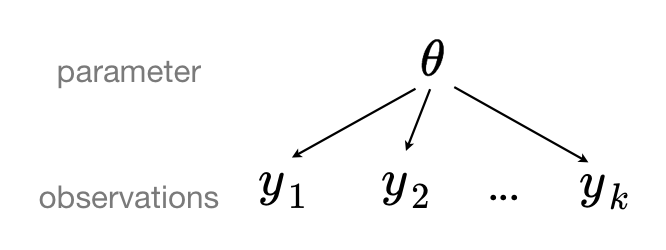

In [3]:
from IPython.display import Image
Image(filename='comppool.png') 

In [38]:
# setup the model

# Jeffery's (scale-invariant) hyperprior
@pm.stochastic(observed=False)
def theta(value=1):
    return 1  # constant for Gaussian

# choose non-informative hyperprior for tau (for distribution of the mean parameter)
tau = pm.Uniform('tau', 0, 1)

# assume means are normally distributed
mu = pm.Normal('mu', mu=theta, tau=tau)

# model mean satisfaction improvement using Normal distribution
meanSI = pm.Normal('mean SI', mu=mu, tau=1/(data_std)**2, value=data_means, observed=True)

# sample
model = pm.Model([meanSI, theta, tau, mu])
mcmc = pm.MCMC(model)
mcmc.sample(iter=61000, burn=1000)  # we fiddled with some of these parameters

 [-----------------100%-----------------] 61000 of 61000 complete in 5.3 sec

Plotting mu


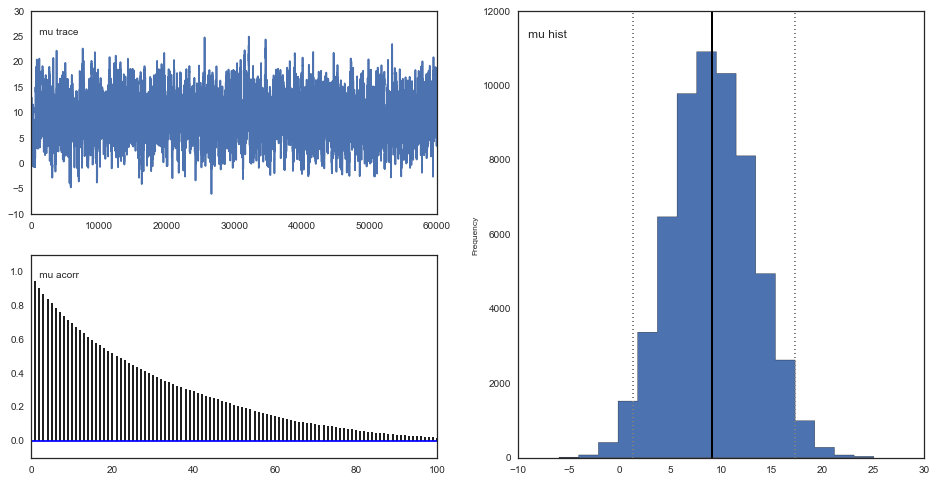

In [39]:
fig = plt.figure(figsize=(16,8))
pm.Matplot.plot(mu, new=False)

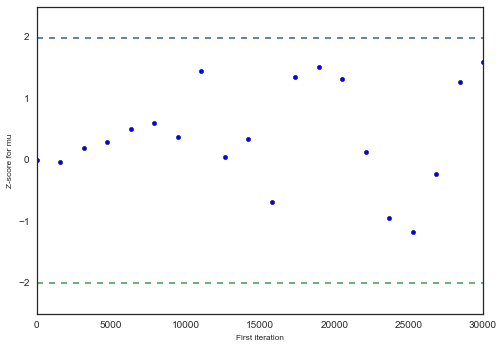

In [40]:
gs1 = pm.geweke(mu.trace(), first=0.1, last=0.5, intervals=20)
pm.Matplot.geweke_plot(gs1, "mu")

In [41]:
mcmc.summary()


mu:
 
	Mean             SD               MC Error        95% HPD interval
	------------------------------------------------------------------
	9.128            4.078            0.124          [  1.339  17.25 ]
	
	
	Posterior quantiles:
	
	2.5             25              50              75             97.5
	 |---------------|===============|===============|---------------|
	1.248            6.328           9.063          11.888        17.193
	

theta:
 
	Mean             SD               MC Error        95% HPD interval
	------------------------------------------------------------------
	9.343            5.34             0.239            [ -0.51  18.37]
	
	
	Posterior quantiles:
	
	2.5             25              50              75             97.5
	 |---------------|===============|===============|---------------|
	0.007            6.044           9.19           12.344        19.087
	

tau:
 
	Mean             SD               MC Error        95% HPD interval
	------------------------

In [42]:
mcmc.stats()

{'mu': {'95% HPD interval': array([  1.33948149,  17.24996147]),
  'mc error': 0.1242963265276353,
  'mean': 9.1276858418197317,
  'n': 60000,
  'quantiles': {2.5: 1.2484091191477318,
   25: 6.3282304129520952,
   50: 9.0625353097004755,
   75: 11.887780153427547,
   97.5: 17.193224401653534},
  'standard deviation': 4.0777680633453137},
 'tau': {'95% HPD interval': array([  9.09407257e-04,   9.48142987e-01]),
  'mc error': 0.0045008801451164437,
  'mean': 0.49538304871776034,
  'n': 60000,
  'quantiles': {2.5: 0.017772302295006093,
   25: 0.24453936257021702,
   50: 0.49790954032253787,
   75: 0.74486224529646972,
   97.5: 0.97479401698790347},
  'standard deviation': 0.28997397890181698},
 'theta': {'95% HPD interval': array([ -0.50970634,  18.37025347]),
  'mc error': 0.23873215927048946,
  'mean': 9.3428235316773733,
  'n': 60000,
  'quantiles': {2.5: 0.0071088282376647882,
   25: 6.0442460223930787,
   50: 9.1895969218682865,
   75: 12.343580014161356,
   97.5: 19.087001279005708}

In [43]:
# test model fit
N = 10  # of iterations for error calculation
error = np.zeros(N)
for i in xrange(N):
    print "\n",i  # status
    #posterior predictive
    SIsim = pm.Normal('postSI', mu=mu, tau=1/(data_std)**2)
    posterior_predictive_model = pm.Model([SIsim])
    mcmc = pm.MCMC(posterior_predictive_model)
    mcmc.sample(iter=51000, burn=1000)
    meansim = np.mean(SIsim.trace())
    error[i] = np.sqrt(np.sum((data_means - meansim)**2))
print "\nmean error ", np.mean(error)
print "std. error ", np.std(error)
print np.mean(error) - 1.96*np.std(error)
print np.mean(error) + 1.96*np.std(error)


0
 [-----------------100%-----------------] 51000 of 51000 complete in 4.2 sec
1
 [-----------------100%-----------------] 51000 of 51000 complete in 4.3 sec
2
 [-----------------100%-----------------] 51000 of 51000 complete in 4.6 sec
3
 [-----------------100%-----------------] 51000 of 51000 complete in 4.9 sec
4
 [-----------------100%-----------------] 51000 of 51000 complete in 5.1 sec
5
 [-----------------100%-----------------] 51000 of 51000 complete in 5.6 sec
6
 [-----------------100%-----------------] 51000 of 51000 complete in 5.7 sec
7
 [-----------------100%-----------------] 51000 of 51000 complete in 5.7 sec
8
 [-----------------100%-----------------] 51000 of 51000 complete in 6.1 sec
9
 [-----------------100%-----------------] 51000 of 51000 complete in 6.5 sec
mean error  31.1751271111
std. error  0.238483989592
30.7076984915
31.6425557307


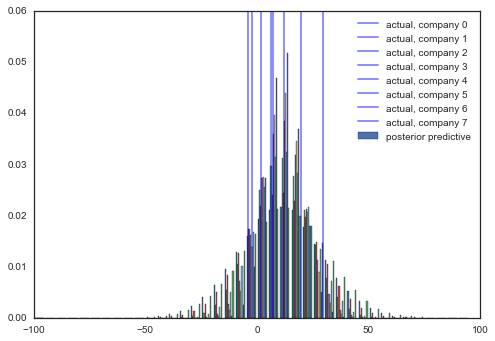

In [44]:
# plot representative posterior predictive distribution
plt.hist(SIsim.trace(), bins=np.arange(-100, 100, 5), normed=True, label = "posterior predictive")
for i, m in enumerate(data_means):
    plt.axvline(m, alpha=0.5, label = "actual, company " + str(i))
plt.legend(loc="best");

<div class="alert alert-warning">
For <strong>complete pooling</strong>, we note the data does not fit the model very well for all points. This is not too surprising, since we have assumed the data come from one distribution with the same distribution for its parameter mu. In other words, we have pooled all the data together, completely ignoring the differences between the individual companies. When the assumptions do not hold for a given company, we do not expect the model to be very accurate for data associated with that company. In this case, we have a number of points distanced from the center of our proposed model distribution where occurrences are supposed to be rarer. Perhaps a more complex model might be more appropriate.
</div>

<div class="alert alert-info">
For <strong>unpooling</strong>, we assume that each observation comes from a Normal distribution with a mean determined from different Normal distributions.
</div>

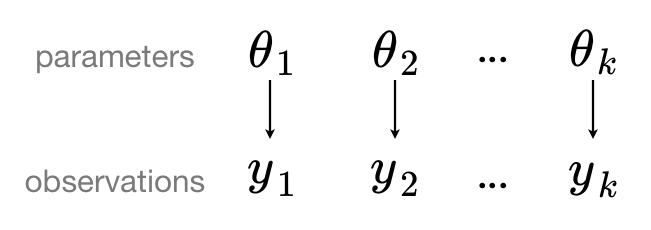

In [26]:
Image(filename='unpooled.png') 


0
 [-----------------100%-----------------] 61000 of 61000 complete in 5.6 sec
mu:
 
	Mean             SD               MC Error        95% HPD interval
	------------------------------------------------------------------
	31.091           18.281           1.546          [ -9.278  65.038]
	
	
	Posterior quantiles:
	
	2.5             25              50              75             97.5
	 |---------------|===============|===============|---------------|
	-8.868           19.622          32.101         43.472        65.764
	

theta:
 
	Mean             SD               MC Error        95% HPD interval
	------------------------------------------------------------------
	31.075           18.382           1.556          [ -8.09   66.694]
	
	
	Posterior quantiles:
	
	2.5             25              50              75             97.5
	 |---------------|===============|===============|---------------|
	-9.063           19.565          32.001         43.66         65.952
	

tau:
 
	Mean         

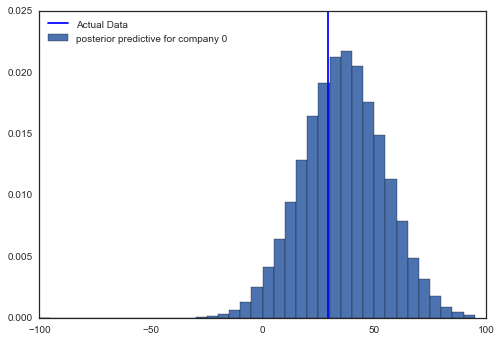

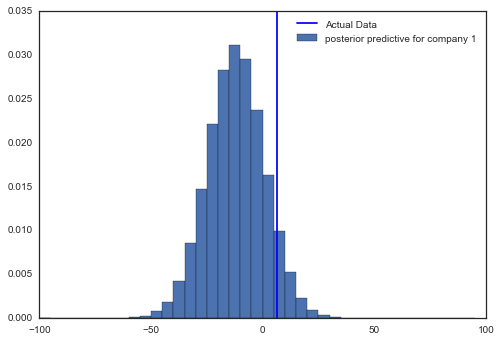

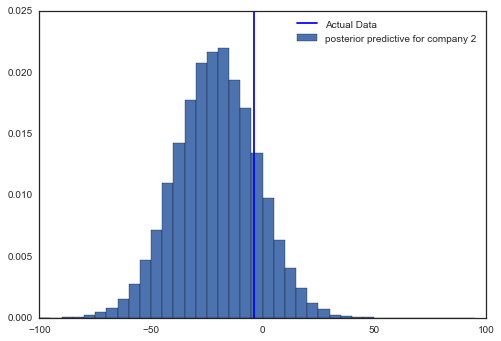

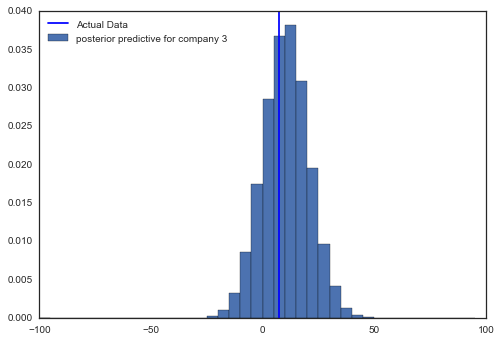

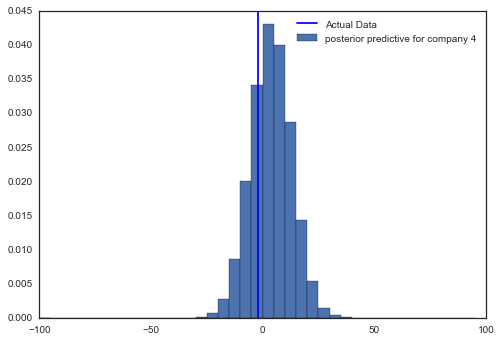

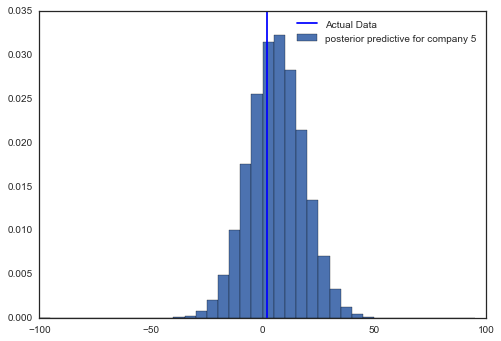

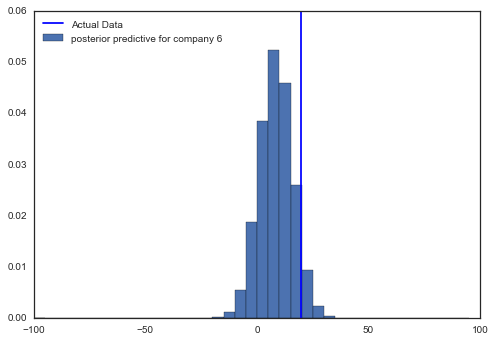

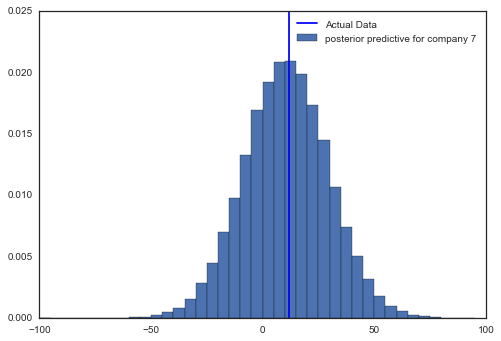

In [46]:
# setup for testing model fit
N = 10  # of iterations for error calculation
error = np.zeros(N)
for j in xrange(N):

    print "\n", j  # status
            
    meansims = np.zeros(len(data_means)) # keep track of means of posterior predictive distributions

    for i in xrange(len(data_means)):

        # Jeffery's (scale-invariant) prior
        @pm.stochastic(observed=False)
        def theta(value=1):
            return 1  # constant for Gaussian

        # choose non-informative prior for tau (for distribution of the mean parameter)
        tau = pm.Uniform('tau', 0, 1)

        # assume means are normally distributed
        mu = pm.Normal('mu', mu=theta, tau=tau)

        # model mean satisfaction improvement using Normal distribution
        # note we use individual mean and standard deviation from the observed data here
        meanSI = pm.Normal('mean SI', mu=mu, tau=1/(data_std[i])**2, value=data_means[i], observed=True)

        # sample
        model = pm.Model([meanSI, theta, tau, mu])
        mcmc = pm.MCMC(model)
        mcmc.sample(iter=61000, burn=1000)  # we fiddled with some of these parameters
        # representative output
        if j==0:
            mcmc.summary()
                
        #posterior predictive
        SIsim = pm.Normal('postSI', mu=mu, tau=1/(data_std[i])**2)
        posterior_predictive_model = pm.Model([SIsim])
        mcmc = pm.MCMC(posterior_predictive_model)
        mcmc.sample(iter=51000, burn=1000)
        meansims[i] = np.mean(SIsim.trace())
        
        # representative output
        if j==0:
            plt.figure()
            plt.hist(SIsim.trace(), bins=np.arange(-100, 100, 5), normed=True, 
                     label = "posterior predictive for company "+str(i))
            plt.axvline(data_means[i], label = "Actual Data")
            plt.legend(loc="best");
    
    error[j] = np.sqrt(np.sum((data_means - meansims)**2))  # difference between observed value and respective mean
    
print "\nmean error ", np.mean(error)
print "std. error ", np.std(error)
print np.mean(error) - 1.96*np.std(error)
print np.mean(error) + 1.96*np.std(error)

In [47]:
error

array([ 29.18089556,  37.42052594,  51.63730811,  46.05683092,
        34.25550971,  42.00155114,  30.07036676,  23.26127385,
        48.93611947,  27.56247707])

<div class="alert alert-warning">
For <strong>unpooling</strong>, the model is based on a distribution with 8 individual distributions for its mean, 1 for each individual company. In contrast to complete pooling where we have assumed the data came from a distribution with the same distribution for its mean thus completely ignoring the differences between the individual companies, here with unpooling we have taken an approach at the other extreme, treating each data point as being completely unrelated to the others. The problem with this model is related to overfitting: it can lead to noisy estimates, particularly when we do not have much data for each company. From the plots we can still see discrepancies between the mode of the posterior predictive distribution and the actual value of the data point for the respective company in many cases.
</div>

<div class="alert alert-info">
For <strong>partial pooling</strong>, we try to reach a compromise between the two above extreme naive approaches.  In this case, we assume that each observation comes from a Normal distribution with 8 individual distributions for its mean corresponding to the 8 companies, but whereas those distributions for the mean share common hyperparameters (i.e. group mean).
</div>

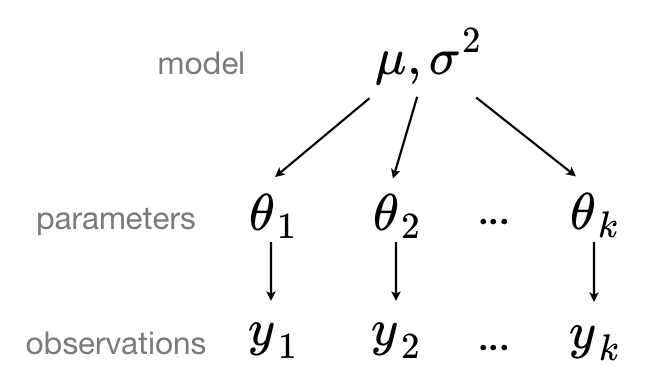

In [48]:
Image(filename='hierarch.png') 

In [51]:
#Jeffery's (scale-invariant) prior
@pm.stochastic(observed=False)
def theta(value=1):
    return 1  # constant for Gaussian

# choose non-informative prior for tau (for distribution of the mean parameter)
tau = pm.Uniform('tau', 0, 1)

# assume means are normally distributed
mu = pm.Container([pm.Normal('mu_%i' % i, mu=theta, tau=tau) for i in range(len(data_means))])

# model mean satisfaction improvement using Normal distribution
# meanSI = pm.Normal('mean_SI', mu=mu, tau=1/(data_std)**2, value=data_means, observed=True)
meanSI = pm.Container([pm.Normal('mean_SI', mu=mu[i], tau=1/data_std[i]**2, 
                      value=data_means[i], observed=True) for i in range(8)])

# sample
model = pm.Model([meanSI, theta, tau, mu])
mcmc = pm.MCMC(model)
mcmc.sample(iter=61000, burn=1000)  # we fiddled with some of these parameters
mcmc.summary()

 [-----------------100%-----------------] 61000 of 61000 complete in 21.1 sec
mu_2:
 
	Mean             SD               MC Error        95% HPD interval
	------------------------------------------------------------------
	8.515            4.29             0.247          [  0.212  16.906]
	
	
	Posterior quantiles:
	
	2.5             25              50              75             97.5
	 |---------------|===============|===============|---------------|
	-0.124           5.788           8.554          11.429        16.637
	

mu_0:
 
	Mean             SD               MC Error        95% HPD interval
	------------------------------------------------------------------
	8.957            4.378            0.251          [  0.413  17.477]
	
	
	Posterior quantiles:
	
	2.5             25              50              75             97.5
	 |---------------|===============|===============|---------------|
	0.376            6.103           8.979          11.899        17.451
	

theta:
 
	Mean        


0
 [-----------------100%-----------------] 61000 of 61000 complete in 4.9 sec
1
 [-----------------100%-----------------] 61000 of 61000 complete in 5.2 sec
2
 [-----------------100%-----------------] 61000 of 61000 complete in 5.6 sec
3
 [-----------------100%-----------------] 61000 of 61000 complete in 5.7 sec
4
 [-----------------100%-----------------] 61000 of 61000 complete in 6.1 sec
5
 [-----------------100%-----------------] 61000 of 61000 complete in 6.6 sec
6
 [-----------------100%-----------------] 61000 of 61000 complete in 7.0 sec
7
 [-----------------100%-----------------] 61000 of 61000 complete in 6.8 sec
8
 [-----------------100%-----------------] 61000 of 61000 complete in 7.5 sec
9
 [-----------------100%-----------------] 61000 of 61000 complete in 7.6 sec
mean error  30.0638577305
std. error  0.187939425037
29.6954964574
30.4322190035


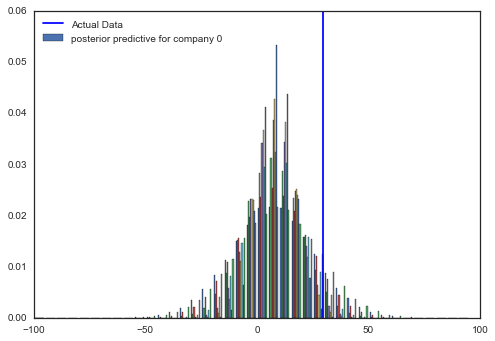

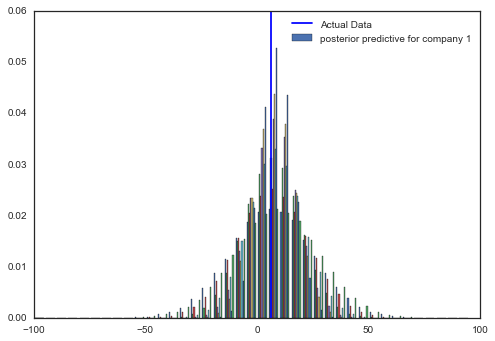

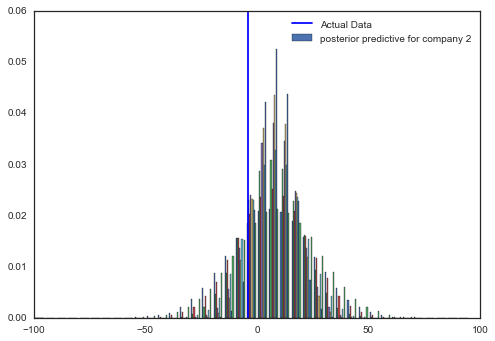

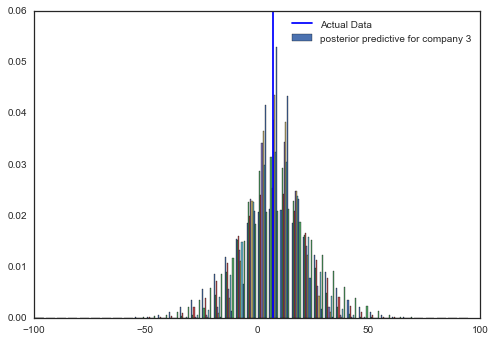

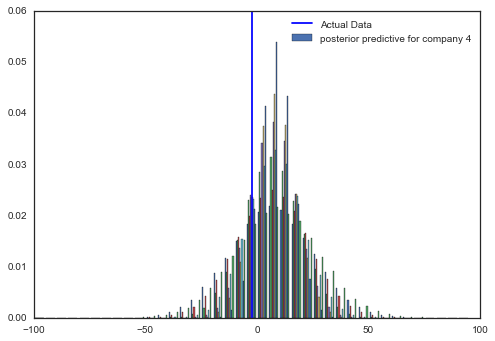

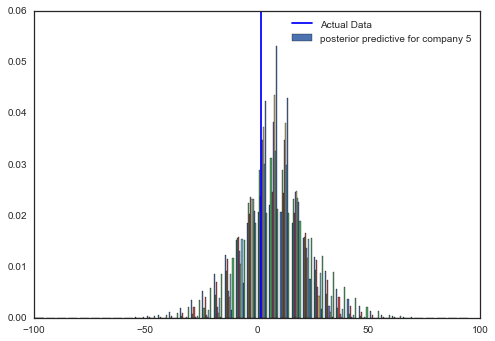

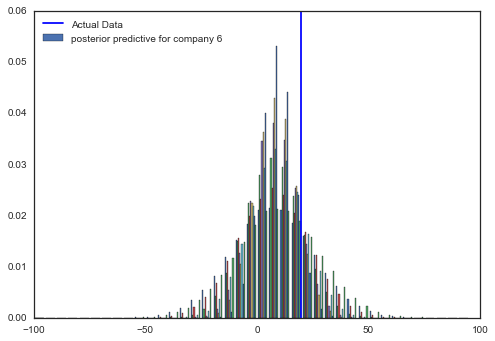

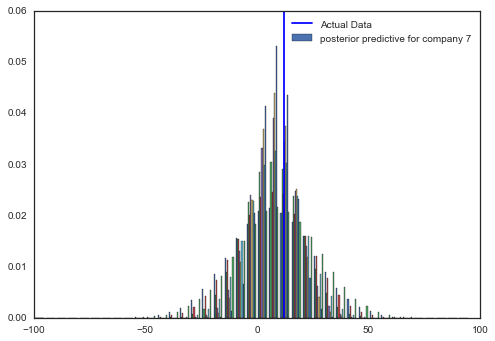

In [52]:
# test model fit
N = 10  # of iterations for error calculation
error = np.zeros(N)
for j in xrange(N):

    print "\n", j  # status
            
    meansims = np.zeros(len(data_means)) # keep track of means of posterior predictive distributions

    for i in xrange(len(data_means)):
        #posterior predictive
        SIsim = pm.Normal('postSI', mu=mu[i], tau=1/(data_std)**2)
        posterior_predictive_model = pm.Model([SIsim])
        mcmc = pm.MCMC(posterior_predictive_model)
        mcmc.sample(iter=61000, burn=1000)
        meansims[i] = np.mean(SIsim.trace())
        
        # representative plot 
        if j==0:
            plt.figure()
            plt.hist(SIsim.trace(), bins=np.arange(-100, 100, 5), normed=True, 
                     label = "posterior predictive for company "+str(i))
            plt.axvline(data_means[i], label = "Actual Data")
            plt.legend(loc="best");
        
    error[j] = np.sqrt(np.sum((data_means - meansims)**2))
    
print "\nmean error ", np.mean(error)
print "std. error ", np.std(error)
print np.mean(error) - 1.96*np.std(error)
print np.mean(error) + 1.96*np.std(error)

<div class="alert alert-warning">
For <strong>partial pooling</strong>, by assuming that each individual data "set" is distributed according to a group distribution -- which we simultaneously estimate -- we hope to obtain better predictions. From the plots we can see there are still differences between the mode of the posterior predictive distribution and the actual value of the data point for the respective company in many cases, but that the differences do not seem as large compared to the unpooled model. <br><br>

We calculated an error measure above (e.g. RMSE, comparing value of reported mean with the mean of the posterior predictive distribution) for each of the models for comparison. Note we ran N=10 iterations due to time constraints; increasing N may provide more precise estimates: <br><br>
<ul>
<li> 95% Confidence Intervals for the error estimate
<li> complete pooling: 31.18 +/- 0.24
<li> unpooled: 37.04 +/- 9.26
<li> partial pooling: 30.06 +/- 0.18 <br><br>
</ul>

From a visual inspection of the plots, the two naive approaches -- complete pooling and unpooled -- seem to perform worse than partial pooling. The point estimates would also suggest that unpooled performs worse than complete pooling in this case (both underperforming partial pooling), although the we cannot be confident in this conclusion given the wide confidence interval for the unpooled case. Increasing the number of iterations when calculating the error, particularly for the unpooled case, would narrow this intervals. Nevertheless, in general, using partial pooling as a compromise would appear to be justified.

<br><br> Note, however, we have made several modeling assumptions, including the form of various distributions (e.g. Normal), and that the variance of the mean is fixed. Changing the distributions used, or modeling the variance as well, may produce different results. Furthermore, with time permitting, we could increase the number of samples taken per iteration, and performing thinning to reduce autocorrelation, in a future investigation.
</div>

# Problem 2: Motif Finding Using Gibbs

One interesting problem in bioinformatics is that of finding common subsequences of nucleotid bases (these subsequences are called motifs) that repeat themselves within larger DNA sequences. The problem is relevant for genetics because locating the positions of these motifs within the DNA sequence helps in the understanding of how genes are regulated.

Suppose that you are a biologist who is analyzing genetic material collected in a nearby asteroid. The DNA of this extraterrestrial form of life is formed as a sequence of $n_B = 5$ nucleotide bases. Let us label these extraterrestrial nucleotides and put them in a vector $\mathbf{b} = [\rm{M}, \rm{0}, \rm{2}, \rm{A}, \rm{7}]$. You have a DNA sample $\mathcal{S}$ consisting of $p=20$ sequences of DNA, each of them with a lenght $l=200$ nucleotide bases that you can find in <a href="HW3/Sequences_new.dat">this file</a>. Each row of the file is a DNA sequence. You are asked to find a motif of $q = 5$ consecutive nucleotides hidden in the background that appears to repeat itself very often in the DNA you were given, but that appears only once in each of the sequences.

Let us formalize the problem. The starting positions of the motif within each sequence (our missing data in the problem) can be represented by the set of random variables:

$$
\mathcal{A} = \left\{a_k, k = 1,...,p\right\}
$$

The motif has to start somewhere within the sequences and so for each sequence $\mathcal{S_k}$:

$$
\sum_{i=1}^{l}P(a_k=i) = 1
$$

What we are after is the joint distribution $P(\mathcal{A}|\mathcal{S})$ for the motif alignment (i.e., its starting position) being $a_k$ for sequence $\mathcal{S}_k$. As shown in [this paper](http://www.cs.cmu.edu/~epxing/Class/10810/readings/liu.pdf), for each sequence $\mathcal{S}_k$ (think of each sequence as a dimension of our parameter space) we can obtain the conditional probability: 

$$
P(a_k=i|\mathcal{A_{\hat{k}}},\mathcal{S})=\frac{1}{Z}\prod_{j=1}^q\left(\frac{\mathbf{\hat{\theta}_j}}{\mathbf{\hat{\theta}_0}}\right)^{s_{i+j-1}}
$$

where $\mathcal{A_{\hat{k}}}$ refers to the alignments in all sequences other than $\mathcal{S}_k$, and $Z$ is a normalization factor. Of the other quantities, $s_x$ is a vector index for the *x-th* position in the sequence, with length $q$. It takes a value of 1 at the entry that in $\mathbf{b}$ corresponds to the base at position $x$ and 0 for all other entries. Finally, vectors $\mathbf{\hat{\theta_j}}$ and $\mathbf{\hat{\theta_0}}$ contain respectively the probabilities of observing the $q$ bases at the corresponding position of the current sequence, and the probabilities of finding the same bases in the background. It is important to note that the power, division, and multiplication of vectors in the equation above is performed entry-wise.

<div class="alert alert-info">
Reference: Gibbs Sampling for Motif Detection (YouTube), https://www.youtube.com/watch?v=KqquwB_kHvU <br><br>

The challenge is to identify the hidden motif in the genetic sequences, if it exists at all. The hidden motif is assumed to exist in each of the 20 sequences, and we are given that the motif is of length 5. An outline of the approach we intend to use is as follows: <br><br>

1. We isolate the first sequence, and build probabilistic data based on the contents of the remaining sequences. We will proceed, initially, to choose a random starting position for the motif of length 5 in each of the remaining sequences. <br><br>
2. We build a table of the counts of the "residues": there are $q=5$ residues (e.g. "characters") in the hidden motif, and so we have five "main" columns in the table. Columns 1-5 are associated with the 1st, 2nd, 3rd, 4th, and 5th positions of the hidden motif. We have $n_b=5$ possible residue identities (M, 0, 2, A, 7), so we have five rows in the table, one for each unique residue identity. We look at all of the unchosen sequences (i.e. every sequence but the isolated first sequence), and count how many times each unique residue identity appears in the specific position 1-5, entering the total count in the appropriate column. <br><br>
3. We build a sixth column, column "0" (n.b. our question appears to be setup to treat this as a separate vector), and count how many of each unique residue identity appears in the background (i.e. not in any position considered to be part of a motif, such that the background consists of $200-5=195$ residues for each sequence). <br><br>

Therefore, our constructed table will generally have the following structure: <br>
<blockquote>
-- 0  1  2  3  4  5 <br>
M <br>
0 <br>
2 <br>
A <br>
7 <br>
</blockquote>

where we expect the counts in column 0 to add up to <strong>3705</strong> (19 unselected sequences x 195 background residues), and the counts in each of colums 1 to 5 to add up to <strong>19</strong> (each unselected sequence will have have one residue in the respective position). <br><br>

4. We can then use the table of counts to construct a probability matrix, where for each column (including the background counts) we take the count for each entry and divide by the sum of all entries in that column. This makes sense since the lowest count in a column will form the lowest proportion of the total counts for that column, and should thus be associated with the lowest probability. However, since we will later use these probabilities to calculate a "likelihood" using the formula given above, a zero probability entry in this matrix will throw this calculation off (and it is unrealistic to assume that the actual probability is strictly zero anyway). To address this issue, we add a <strong>pseudocount</strong> to each entry of the table before calculating the probability for the matrix; we add 0.5 to each entry, but we could have used 0.1, 1, or any other number. <br><br>

5. We can now calculate a weight for each possible motif position in the isolated first sequence. Since our sequence is 200 residues long and our hidden motif is 5 residues long, there are (200-5+1=196) possible starting positions for the hidden motif. Looking at the very first starting position, we examine the string that is 5 residues long from that starting position, and calculate the probability of obtaining that sequence of 5 residues. This can be done by multiplying the individual probabilities of having the specific residue in the respective corresponding positions together, and dividing by the product of the probabilities of having those specific residues in the background (reference: example at https://youtu.be/-cuduZSC_ks). The probabilities are obtained from the probability matrix constructed above (i.e. we derived the probability data from the unselected sequences, to be applied to our isolated sequence). We repeat this calculation for each of the remaining 195 possible starting positions, to obtain a set of 196 weights. All 196 weights can be <strong>normalized</strong> (by dividing by the sum of all weights) to convert these weights into a set of probabilities, and thus a probability distribution.<br><br>

6. From the probability distribution obtained, we now <strong>randomly sample</strong> to obtain a proposed position for our hidden motif. Positions with higher probabilities will have a higher chance of being drawn at this sampling step, but it is not guaranteed. This randomization allows for the possibility of different positions to be selected, and allows us to avoid local minimum problems. The selected position becomes the starting position for the motif for the first sequence. <br><br>

7. We now repeat steps 2-6 above for each of the remaining 19 previously unchosen sequences, resulting in an updated set of starting positions for the set of 20 sequences. This is one iteration of our Gibbs sampler.<br><br>

8. We now repeat steps 2-7 again, in subsequent iterations of our Gibbs sampler. We expect the proposed positions for the hidden motif within the 20 sequences to continuously change; if they fail to change, this means the algorithm has converged, with the steady-state positions representing the desired alignments of the hidden motif. We can then print out the hidden motif -- the first 5 characters starting at each of those positions in the 20 sequences.<br><br>

<strong>We note there is no guarantee the algorithm will converge to the optimum value (the true motif position in each of the sequences) because it is probabilistic in nature</strong>. Note that is was also necessary to correctly specify the length of the hidden motif in our implementation.
</div>

Your only task is to design a Gibbs algorithm that samples the joint probability $P(\mathcal{A}|\mathcal{S})$. Your algorithm should converge and provide the alignments of the motif and the secret motif itself. Here are some hints/tasks that should help you and that will help the TF grading your homework:

(a) Describe the equation for the conditional probabilities in your own words, and make sure you understand it before you code anything. Be as explicit as possible.

$$
P(a_k=i|\mathcal{A_{\hat{k}}},\mathcal{S})=\frac{1}{Z}\prod_{j=1}^q\left(\frac{\mathbf{\hat{\theta}_j}}{\mathbf{\hat{\theta}_0}}\right)^{s_{i+j-1}}
$$

<div class="alert alert-warning">
The probability that the hidden motif starts at position $i$ in a given sequence is conditional on the starting positions of all other sequences. The calculation involves computing a product of the probabilities of observing the specific nucleotides (we called them "residues" above) in each of the 1st, 2nd, 3rd, 4th, and 5th positions, divided by the probability of seeing that nucleotide in each of the respective positions as part of the background noise. <br><br> Since we will have a set of at most 200 such probable starting positions (actually it is 196 as noted above), we can sum up all of the probabilities to be used as the normalizing constant from which we can divide the probability of seeing the hidden motif at position $i$, so that we end up with a probability distribution from which we can sample.
</div>

(b) Start by assigning random starting positions for the $q$-long motif in all sequences. Then exclude a particular sequence $S_k$ (your current sequence) and use the remaining sequences to construct $\mathbf{\Theta}$ as a probability matrix from counting the number of times that the *i-th* base appears in position $j$ of the motif given the current alignments. Construct also a vector $\mathbf{\hat{\theta_0}}$ from counting the number of times that the *i-th* base appears in the background. Note that the vectors $\mathbf{\hat{\theta_j}}$ are the columns of matrix $\mathbf{\Theta}$.

In [53]:
# http://stackoverflow.com/questions/15138614/how-can-i-read-the-contents-of-an-url-with-python
import urllib
link = "http://localhost:8888/notebooks/HW3/Sequences_new.dat"
f = urllib.urlopen(link)
myfile = f.read()

In [54]:
# http://stackoverflow.com/questions/172439/how-do-i-split-a-mult-line-string-into-multiple-lines
import string
sequences = string.split(myfile, '\n')
sequences = sequences[0:20] # remove last blank entry

In [55]:
q = 5  # motif length

b = {'M':0, '0':1, '2':2, 'A':3, '7':4}  # save bases in a dictionary and assign index
B = len(b)

p = 20  # number of sequences
l = 200  # length of each sequence

assert len(sequences) == p
for i in xrange(p):
    assert len(sequences[i]) == l

In [56]:
# randomly initialize starting positions
startpos = np.random.randint(0, l-q+1, size=p)

In [57]:
# we write a function that constructs the probability matrix, given an excluded sequence
# note we have incorporated the background count vector as added column 0 of our probability matrix
def prob_matrix(excl_seq):
    
    Theta = np.zeros((B, q + 1))  # rows represent residue identities, q represents positions within the motif
    
    ####
    #
    # create count matrix
    #
    ####
    
    for seqidx in xrange(p):  # loop through sequences
        if seqidx != excl_seq:  # ignore excluded sequence
            
            for char in xrange(l):  # loop through characters of the sequence
                if (char < startpos[seqidx]) or (char >= (startpos[seqidx] + q)):  # background character
                    Theta[b[sequences[seqidx][char]], 0] += 1  # increment column 0, row given by residue
                else:
                    col = char - startpos[seqidx] + 1  # reformat as 1-index
                    Theta[b[sequences[seqidx][char]], col] += 1  # increment column corresponding to position

    # checking checksums                
    assert np.sum(Theta[:,0]) == ((p - 1) * (l - q))  
    for i in xrange(1, q):
        assert np.sum(Theta[:,i]) == (p - 1)
    
    ####
    #
    # convert to probabilities
    #
    ####
    
    # add pseudocount to all entries to avoid 0 probabilities
    Theta += 0.5
    
    # http://stackoverflow.com/questions/16202348/numpy-divide-row-by-row-sum
    Theta = Theta * 1.0 / Theta.sum(axis=0, keepdims=True)
        
    return Theta


(c) From $\mathbf{\Theta}$ and $\mathbf{\theta_0}$, derive the conditional probability over all possible alignments for your current sequence and draw a sample from it. This sample will be your updated alignment for the current sequence.

In [58]:
# we write a function that provides the updated alignment for an identified sequence
# this function will call prob_matrix, as defined above, and uses probabilties in the returned matrix
# to determine a probability distribution for possible aligments
def get_new_alignment(seq_index):
    
    # possible starting positions (0 - indexed)
    max_i = l - q + 1
    act_k = np.zeros(max_i)
    
    pm = prob_matrix(seq_index)  # get probability matrix
    s_k = sequences[seq_index]  # get sequence as a string
    
    for i in xrange(max_i):
        for char in xrange(i, i+q):
            # calculate ratio, extract character and look up probability in probability matrix
            # work in logspace just in case
            act_k[i] += np.log(pm[b[s_k[char]], char - i + 1]) - np.log(pm[b[s_k[char]], 0]) 
        
    # normalize: http://atpassos.me/post/44900133731/normalizing-log-probabilities-with-numpy
    a = np.logaddexp.reduce(act_k)
    act_k = np.exp(act_k - a)

    # randomly sample from probability distribution obtained and return index
    return np.random.choice(max_i, p=act_k)

(d) Iterate over all $p$ sequences. Such iteration over sequences is only one Gibbs iteration. After enough Gibbs iterations you should start noticing that the algorithm has converged.

In [60]:
N = 1000  # max number of Gibbs iterations
converge = False

# (repeat) randomly initialize starting positions
startpos = np.random.randint(0, l-q+1, size=p)

for i in xrange(N):
    # perform one Gibbs iteration
    oldpos = startpos.copy()
    if i % 100 == 0:
        print startpos
    for seq in xrange(p):
        startpos[seq] = get_new_alignment(seq)  # update alignment
        
    # check for convergence
    if np.array_equal(oldpos, startpos):
        converge = True
        print "converged after %i iterations" % i
        print "alignments: ", startpos
        # print the motif
        for seq in xrange(p):
            print sequences[seq][startpos[seq]:startpos[seq]+q]
        break
        
if not converge:
    print "did not converge"

[124 147 119 126  59 104 182  21  51 150 122  69 154  22  49 120 118  81
 125 156]
converged after 60 iterations
alignments:  [ 62 150  30 153  26  57  51  97  70 154  37 124  61  85 165 124  84 144
  44  88]
AM207
AM207
AM207
AM207
AM207
AM207
AM207
AM207
AM207
AM207
AM207
AM207
AM207
AM207
AM207
AM207
AM207
AM207
AM207
AM207


<div class="alert alert-warning">
The alignments of the hidden motif in the 20 sequences are: <br>
    [ 62 150  30 153  26  57  51  97  70 154  37 124  61  85 165 124  84 144 44  88] <br><br>
    
The hidden motif is: AM207 <br><br>

We note that our algorithm did not always converge, which is consistent with our earlier discussion (when it does not, it appears to have difficulty finding patterns with 'A' as the first letter). However, when we ran the algorithm a few times, we were able to obtain convergence in a reasonable number of trials in at least one instance, and in those cases, convergence was quite quick (less than 100 iterations).
</div>

# Problem 3: Optimizing Hand Luggage

You are going on a trip and have to optimize your hand luggage, but thanks to your cheap flight ticket, the weight of the hand lugagge is restricted and you are sure the airline will enforce the upper limit. You have a set of presents that you want to bring to the relatives you are visiting, but you have to notice that they don't all fit into your suitcase. 

This problem is also called the knapsack problem: given a set of items, each has its weight and value, determine which items should be included into your suitcase, so that the total weight does not exceed some value $W$ and the total value is maximal. The kind of the knapsack problem when each item can be included into the collection at most once is called the 0/1 knapsack problem. Your task is to solve this problem using simulated annealing. 

Implement simulated annealing to solve this problem with the list of items below. Which ones would you pick for your suitcase? Plot and discuss your optimization scheme and results. 
Compare your solution to a greedy algorithm, which sorts the items by the ratio $\frac{v_i}{w_i}$ and puts them into the suitcase consecutively.

In [61]:
# here is your data:

#number_of_data_points
N = 100

#total_weight_limit 
W = 3000

# weight of all the different items
w = np.array([  38,  236,  909,   73,  768,  906,  716,  646,  848,  961,  145,
        130,  973,  584,  750,  509,  391,  282,  179,  277,  255,  358,
        915,  469,  908,  253,  491,  669,  926,  399,  563,  581,  216,
        984,  754,  504,  479,  865,   87,  142,  394,    8,  320,  830,
        535,  314,  514,  897,  317,  210,  265,  729,  654,  628,  432,
        634,  457,  543,   72,  388,  455,  918,  562,  314,  516,  965,
        793,  498,   44,  589,   27,  821,  337,  622,  884,  298,  467,
         16,   65,  197,   26,  368,  739,  472,  904,  283,  666,  617,
         23,  778,  708, 1000,  127,  280,  382,  357,  156,  934,  314,
        596])

# value of all different items
v = np.array([36, 38, 30, 32, 40, 45, 45, 37, 49, 40, 44, 30, 31, 47, 43, 33, 30,
       43, 36, 50, 36, 32, 42, 41, 37, 43, 38, 41, 42, 41, 50, 34, 37, 37,
       43, 34, 46, 48, 30, 43, 40, 47, 37, 40, 50, 30, 42, 31, 39, 48, 49,
       31, 32, 42, 37, 32, 40, 30, 39, 48, 36, 32, 37, 37, 46, 45, 35, 47,
       40, 50, 46, 35, 43, 47, 48, 31, 50, 40, 30, 37, 30, 49, 47, 44, 43,
       50, 50, 41, 36, 43, 45, 39, 32, 37, 35, 34, 35, 38, 43, 47])

<div class="alert alert-info">
Reference: http://www.colinrickert.com/sim-anneal-knapsack.pdf <br><br>

<blockquote>By far the simplest and most straightforward approximation algorithm for the knapsack problem is a simple greedy strategy where by items are ranked and sorted based on their cost/weight ratios (the higher the better). Items are then taken in order until the capacity has been reached. This approach may seem naïve but it is in fact surprisingly effective, especially in problems where there is a very large standard deviation of item costs and weights and extreme outliers in the ratios of costs/weights exist as a result.</blockquote>

We implement the greedy algorithm first:
</div>

In [62]:
# greedy algorithm calculates ratio of value/weight for each item, and then puts them into the bag in descending order

ratios = v * 1.0 / w

# choose some way of identifying ratios in descending order, here we work with the indices instead of sorting
assert len(ratios)==N
ranks = np.argsort(ratios)[::-1] # descending indices

tot_weight = 0
tot_value = 0
item_IDs = []  # store info on packed items

for i in ranks:
    if (tot_weight + w[i] > W):
    # packing next item would make bag overweight, do not pack
        break
    
    item_IDs.append((i, w[i], v[i], v[i]*1.0/w[i])) # pack and save info
    tot_weight += w[i]
    tot_value += v[i]

In [63]:
print "number of items packed: %i" % len(item_IDs)
print "total weight: %i, weight used: %i" % (W, tot_weight)
print "total value: %i" % tot_value
print "(item number, weight, value, value-to-weight ratio): "
item_IDs

number of items packed: 23
total weight: 3000, weight used: 2806
total value: 897
(item number, weight, value, value-to-weight ratio): 


[(41, 8, 47, 5.875),
 (77, 16, 40, 2.5),
 (70, 27, 46, 1.7037037037037037),
 (88, 23, 36, 1.5652173913043479),
 (80, 26, 30, 1.1538461538461537),
 (0, 38, 36, 0.94736842105263153),
 (68, 44, 40, 0.90909090909090906),
 (58, 72, 39, 0.54166666666666663),
 (78, 65, 30, 0.46153846153846156),
 (3, 73, 32, 0.43835616438356162),
 (38, 87, 30, 0.34482758620689657),
 (10, 145, 44, 0.30344827586206896),
 (39, 142, 43, 0.30281690140845069),
 (92, 127, 32, 0.25196850393700787),
 (11, 130, 30, 0.23076923076923078),
 (49, 210, 48, 0.22857142857142856),
 (96, 156, 35, 0.22435897435897437),
 (18, 179, 36, 0.2011173184357542),
 (79, 197, 37, 0.18781725888324874),
 (50, 265, 49, 0.18490566037735848),
 (19, 277, 50, 0.18050541516245489),
 (85, 283, 50, 0.17667844522968199),
 (32, 216, 37, 0.17129629629629631)]

<div class="alert alert-info">
Additional reference: http://www.math.wustl.edu/~feres/Math350Fall2012/Projects/mathproj09.pdf <br><br>

The basic strategy for applying the simulated annealing approach is as follows: <br>

<blockquote>
1. Pick an item not yet in the bag at random with equal probability <br>
2a. If adding new item to the bag will not result in an overweight bag, add it to the bag <br>
2b. If adding the new item to the bag results in an overweight bag, keep dropping randomly selected items in the bag (which may include the new item) until the bag is no longer overweight. <br>
2c. The resulting bag is our proposal. <br>
3. Assess the change in energy; if energy has improved, accept the proposal, else accept the proposal with some probability $e^{-\beta\Delta E}$ (and reject otherwise), where $\beta = 1/(kt)$, $\Delta E = \Delta E_{t+1} - \Delta E_t$, and $k$ is a constant.
</blockquote>

</div>

In [67]:
# we define a function to calculate "Energy" at a given time step
# it seems like it would be natural to maximize the values of items in the bag (i.e. minimize the negative)
def energy(items, n_bag):
    ctr = 0
    for i in xrange(n_bag):
        ctr += v[items[i]]
    # print "|energy| of bag ", ctr
    return -ctr

In [68]:
def bag_weight(items, n_bag):
    # return weight of the given bag (n.b. value of bag is given by `energy`)
    tot_weight = 0
    for i in xrange(n_bag):
        tot_weight += w[items[i]]
    return tot_weight
    
# propose new bag
# L is the number of attempts to add an item to the bag
# in our implementation, we are storing items in the bag (at the beginning) and items not in the bag (at the end)
# in the same list; return pointer to end of proposed bag and the proposed bag
def change_bag(items, n, L=1): 
    q = items.copy()
    n_bag = n
    checksum = np.sum(q) # just to check we swapped ok
    
    for i in xrange(L):
        if n_bag < N:
            # pick an item not in bag at random, and add to the bag
            # we move a random item to the "end" of the bag, then add it
            pickitem = np.random.randint(n_bag, N)
            temp = q[n_bag]
            q[n_bag] =  q[pickitem]
            q[pickitem] = temp
            assert np.sum(q)==checksum
            n_bag += 1
            
            while bag_weight(q, n_bag) > W:
                # bag is too heavy, we need to drop items from the bag
                # we move a random item to the "end" of the bag, then drop it
                # print "bag weighs %i, max capacity %i, dropping item " % (bag_weight(q, n_bag), W)
                pickitem = np.random.randint(0, n_bag)
                temp = q[n_bag-1]
                q[n_bag-1] =  q[pickitem]
                q[pickitem] = temp
                assert np.sum(q)==checksum
                n_bag -= 1
                
    return q, n_bag

In [69]:
def sa(items, init_temp, thermostat, ftol, itol, otol, reannealing, k=1): 
        
    bag_values = []  # sequence of energy values
    min_bag_value = 0  # store best bag composition seen so far
    best_bag = []  # store items for best bag
    
    m = 500 # iterations before checking function tolerance (tried various settings)
    it = 0 # acceptances counter
    atp = 0 # total number of iterations
    
    n_bag = 0  # number of items currently in the bag
    prev_E = energy(items, n_bag)  # initial energy
    temperature = init_temp
        
    while True:
        # L = np.floor(temperature).astype(int)  # alternative step size
        L = np.floor(np.sqrt(temperature)).astype(int)  # step size
    
        propose_bag, propose_n = change_bag(items, n_bag, L)
        new_E = energy(propose_bag, propose_n)
        delta_E = new_E - prev_E
        
        if (delta_E < 0) or (np.random.rand() < np.exp(-delta_E/k*temperature)):
            # accept new bag
            items, n_bag = propose_bag, propose_n
            bag_values.append(new_E)
            prev_E = new_E
            it += 1
            # keep track of best bag composition
            if new_E < min_bag_value:
                min_bag_value = new_E
                best_bag = items[:n_bag]
            
        atp += 1
        
        # determine when to reheat
        if (it % reannealing) == 0:
            temperature = thermostat * temperature
            if temperature < 1:
                # reheat
                temperature = 5

        # termination conditions
        if (len(bag_values) > m) and np.std(bag_values[-m:])/np.mean(bag_values[-m:]) < ftol: 
            print 'ftol: convergence'
            break
        if atp > itol:
            print 'itol: maximum iterations reached'
            break
        if (N - n_bag) <= otol:
            print n_bag
            print 'otol: maximum number of items in bag' 
            break

    return best_bag, bag_values  # return indices of items in best bag and sequence of values

In [73]:
# we fiddled around with these parameters
init_temp = 10
thermostat = 0.95
ftol = 0.01
itol = 500000
otol = 0.
reannealing = 100
k = 0.001

items_list = np.arange(0, N) # keeping track of list of all items by item number
bag, value = sa(items_list, init_temp, thermostat, ftol, itol, otol, reannealing, k)

ftol: convergence


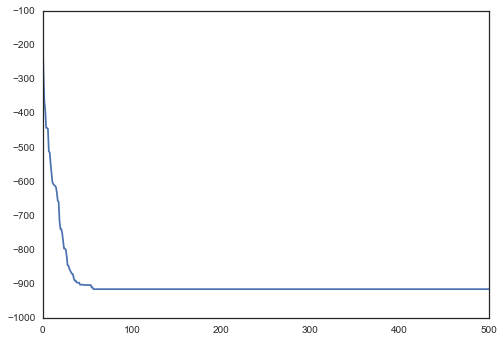

In [74]:
plt.plot(value); # note we are only plotting sequence of accepted values

In [75]:
# output details of best bag
tot_weight = 0
tot_value = 0
item_IDs = []  # store info on packed items

for i in bag:
    item_IDs.append((i, w[i], v[i], v[i]*1.0/w[i]))
    tot_weight += w[i]
    tot_value += v[i]
    
print "number of items packed: %i" % len(item_IDs)
print "total weight: %i, weight used: %i" % (W, tot_weight)
print "total value: %i" % tot_value
print "(item number, weight, value, value-to-weight ratio): "
sorted(item_IDs, key=lambda tup: tup[3], reverse=True)  # print out sorted by ratio for comparison

number of items packed: 23
total weight: 3000, weight used: 2995
total value: 916
(item number, weight, value, value-to-weight ratio): 


[(41, 8, 47, 5.875),
 (77, 16, 40, 2.5),
 (70, 27, 46, 1.7037037037037037),
 (88, 23, 36, 1.5652173913043479),
 (80, 26, 30, 1.1538461538461537),
 (0, 38, 36, 0.94736842105263153),
 (68, 44, 40, 0.90909090909090906),
 (58, 72, 39, 0.54166666666666663),
 (78, 65, 30, 0.46153846153846156),
 (3, 73, 32, 0.43835616438356162),
 (38, 87, 30, 0.34482758620689657),
 (10, 145, 44, 0.30344827586206896),
 (39, 142, 43, 0.30281690140845069),
 (92, 127, 32, 0.25196850393700787),
 (49, 210, 48, 0.22857142857142856),
 (96, 156, 35, 0.22435897435897437),
 (18, 179, 36, 0.2011173184357542),
 (79, 197, 37, 0.18781725888324874),
 (50, 265, 49, 0.18490566037735848),
 (19, 277, 50, 0.18050541516245489),
 (85, 283, 50, 0.17667844522968199),
 (25, 253, 43, 0.16996047430830039),
 (17, 282, 43, 0.1524822695035461)]

<div class="alert alert-warning">
Our best result is a bag of value <strong>916</strong>, with a utilized weight of 2995/3000. <br><br>
The <strong>23</strong> items to be packed are: <br>
[41, 77, 70, 88, 80, 0, 68, 58, 78, 3, 38, 10, 39, 92, 49, 96, 18, 79, 50, 19, 85, 25, 17] <br>
sorted by descending value-to-weight ratio. <br><br>

Note we are not guaranteed to reach a global optima in any given run, even if the algorithm has "converged", since we have defined a particular tolerance for convergence. In theory, however, if we allowed the algorithm to run for infinite time, we could converge to the global optima but this is rarely useful in practice. <br><br>

The details of the best bag and the benchmark are shown below. We can see that by using simulated annealing instead of the greedy algorithm, we are not forced to bag item number 11, which would have been the 15th item packed in the greedy algorithm (or item 32 as the last item before the bag is full); this allows for two different items to be packed which can provide greater value while still guaranteeing that the capacity of the bag is not exceeded.
</div>

# Problem 4: Confusing Classifications

You are a graduate student conducting research in image processing.  You want to test out your latest algorithm, which you decide to call "Ultra-Multilayer Hierarchical Super Convolutionary Neural Network."  However, in order to test out your algorithm, you need a sizable training data set. Luckly, your advisor has generously given you over 10 GB of over one million stock photos of cats and dogs.  Unfortunately, none of the images are labelled.  Fantastic!  You enjoy looking at photos of puppies and kittens in your spare time anyways so you decide to dedicate this entire weekend to labeling all of them. 

<table>
<tr>
 <td><img src="HW3/cat.jpeg" width=150>
 </td>
 <td><img src="HW3/dog.jpeg" width=150>
 </td>
</tr>
</table>

However, after spending two hours looking over hundreds of images, these puppies and kittens are no longer looking so cute.  In fact, you are starting to get disgusted at the idea of looking at another picture of these furry creatures.  

At this time, you decide to tap into the "power of the crowd" by farming out the labeling task to the workers of Amazon Mechanical Turk (MTurk). You decide to hire 3 MTurk workers.  However, you're not sure if these workers are reliable. So, how can you quantify the competency of the workers? In this problem you will develop a model to access the general difficulty of labeling the images of your two classes. 

Classifying items in general can be hard even for humans.  Some items just look alike, even if they actually are from two different classes. The difficulty in categorizing items of a specific class in relation to other classes is summarized by a [confusion matrix](https://en.wikipedia.org/wiki/Confusion_matrix):

$$ \Theta = \left( 
\begin{array}{cc}
1.0 & 0.0 \\
0.5 & 0.5
\end{array}
\right ) $$

This confusion matrix indicates that items of class 1 are very easy to classify, and always correctly labeled, whereas items of class 2 are very hard to classify and labels are basically just random guesses between the two possibilities. 

The models we discussed so far in homework and lecture were pretty low in dimensions. This problem is going to show you that the number of dimensions can grow very fast for some models, making a good sampling strategy crucial. We will only be able to explore a very minimal version of the problem, because of our limited computational resources, but it should be immediately clear how this model would scale for a greater number of classes, workers, and/or items.

Develop a Bayesian model that takes as input a set of (possible erroneous) item labelings and infer the underlying confusion matrix and the true label each data point. To make the model manageable by your laptop, use only one underlying confusion matrix (in principle different people could have different difficulties) two classes for the labels (the confusion matrix is 2x2), and a maximum of 150 data points. 

The model you are after is displayed in the following dependency graph:
<img src="HW3/confusion_model.png" alt="confusion matrix model" width=300>


$$\rho \sim Dir(\alpha) $$

$$z_i \sim Multinomial(\rho)$$

\begin{equation}
\Lambda = \begin{bmatrix}
 \lambda_1 \\
 \lambda_2 \\
\end{bmatrix}
\end{equation}

$$\Theta_{(k,:)} \sim Dir(\lambda_k)$$

$$r_{i,j} \sim Multinomial(\Theta_{(z_i , : )}), \ \forall j \in \{1,...,J\}$$

You're given reports generated by the 3 workers, so $r_{i,1}$ is one label for item $r_i$ and $r_{i,2}$ is another label given from another worker. Note that if the confusion matrix is not the identity matrix then these labels can be different because the workers make mistakes. The arrows in the diagram indicate dependence. So the labelings you observe are dependent on the confusion matrix $\Theta$ and the underlying true label $z_i$ for each item. $N$ is the number of data points you have and as described above you should use $N \leq 150$.

You can see from the diagram that the model uses Multinomials with Dirichlet priors. 

1. Start by describing the model in terms of these distributions, what they mean and what this arrangement means for the form of the labels $z_i$. Discuss the meaning and influence of the hyperparameter $\alpha$ on the true labels of the data.

2. Discuss your selection of the hyperparameter $\Lambda$ and how that influences the confusion matrix $\Theta$.

3. Implement this Bayesian model and sample from the posterior to recover the underlying confusion matrix $\Theta$ and the distribution of the true labels $\rho$.  Note: $\Theta$ is shared by all three workers.

<div class="alert alert-info">
1. This is a hierarchical model which we can use to help us infer the confusion matrix $\Theta$ of the workers and the distribution of the true labels (cat/dog) for the images $\rho$ from the generated worker reports. <br><br>
More specifically, $r_{i,1}$ represents the true reports (that we can observe), which is generated from the unobserved true labels $z_i$ as well as the confusion matrix $\Theta$ of the workers. $\rho$ is a 2 x 1 vector that represents the distribution of cats and dogs among the images, and is parameterized by $\alpha$, which we chose [1, 1] as our prior. It is generally uninformative and does not indicate any imbalance between cats and dogs within the image, although we could change $\alpha$ to suggest such an imbalance is likely to exist (i.e. more of the true labels are likely to be one animal compared to the other.<br><br>


2. The confusion matrix $\Theta$ is generated from a hyperparameter $\Lambda$, which are both 2 x 2 matrices. The first row of these matrices represents the probability that a dog is correctly classified or not, while the second row of these matrices represents the probability that a cat is correctly classified or not. The diagonal contains the probabilities that the correct animal (cat/dog) is classified by the workers. As a prior, we chose to start with  $\Lambda$ as [[10, 1], [1, 10]] assuming that workers will be 10 times as likely to correctly classify a dog or cat than not. This is somewhat arbitrary and we can adjust the rate upwards and downwards, and we could have even chose different rates for dogs and cats.
</div>

In [76]:
# Here is your data
reports = np.load("HW3/reports.npy")

In [77]:
reports

array([[[ 0.,  1.],
        [ 0.,  1.],
        [ 0.,  1.]],

       [[ 1.,  0.],
        [ 1.,  0.],
        [ 1.,  0.]],

       [[ 0.,  1.],
        [ 1.,  0.],
        [ 1.,  0.]],

       [[ 0.,  1.],
        [ 0.,  1.],
        [ 0.,  1.]],

       [[ 0.,  1.],
        [ 1.,  0.],
        [ 0.,  1.]],

       [[ 1.,  0.],
        [ 1.,  0.],
        [ 0.,  1.]],

       [[ 0.,  1.],
        [ 0.,  1.],
        [ 0.,  1.]],

       [[ 0.,  1.],
        [ 0.,  1.],
        [ 0.,  1.]],

       [[ 0.,  1.],
        [ 0.,  1.],
        [ 1.,  0.]],

       [[ 0.,  1.],
        [ 0.,  1.],
        [ 0.,  1.]],

       [[ 0.,  1.],
        [ 0.,  1.],
        [ 0.,  1.]],

       [[ 0.,  1.],
        [ 1.,  0.],
        [ 0.,  1.]],

       [[ 0.,  1.],
        [ 0.,  1.],
        [ 0.,  1.]],

       [[ 1.,  0.],
        [ 0.,  1.],
        [ 0.,  1.]],

       [[ 1.,  0.],
        [ 1.,  0.],
        [ 0.,  1.]],

       [[ 1.,  0.],
        [ 0.,  1.],
        [ 0.,  1.]],

       [

In [78]:
# setup the model
N = 150  # number of images
J = 3    # number of workers

####
#
# Theta
#
####

Lambda = [[10, 1], [1, 10]]  # Row 1 = Class 1, Row 2 = Class e
theta = pm.Container([pm.Dirichlet("theta_%i" % i, theta=Lambda[i]) for i in range(len(Lambda))])

# by default, PyMC's Dirichlet doesn't track the last entry, because it is deterministic
# https://phaethonprime.wordpress.com/2015/06/25/bayesian-modeling-with-pymc-dirichlet-and-a-custom-stochastic/
# We use `CompletedDirichlet` to make subsequent calculations more straightforward

theta_full = pm.Container([pm.CompletedDirichlet("theta_full_%i" % i, theta[i]) for i in range(len(Lambda))])

####
#
# Rho
#
####

rho = pm.Dirichlet("rho", theta=[1, 1])  # parameter is actually alpha from the diagram above, which we fix

####
#
# z (true label)
#
####

z = pm.Container([pm.Multinomial("z_%i" % i, p=rho, n=1) for i in range(N)]) 

####
#
# r (ratings)
#
####

# define a custom likelihood function (we have data for this - `observed`)
@pm.observed
def likelihood(value=reports, theta_full=theta_full, z=z):
    all_l = 0
    for i in range(N):
        for j in range(J):
            idx = np.argmax(z[i])  # determine likely class, and extract appropriate row of theta given the truth
            all_l += pm.multinomial_like(value[i][j], n=1, p=theta_full[idx])  # log-likelihood, reports independent
            
    return all_l

In [80]:
model = pm.Model([theta_full, rho, z, likelihood])
mcmc = pm.MCMC(model)
mcmc.sample(iter=11000, burn=1000, thin=20)

 [-----------------100%-----------------] 11001 of 11000 complete in 1756.9 sec

Plotting theta_full_0_0_0
Plotting theta_full_0_0_1


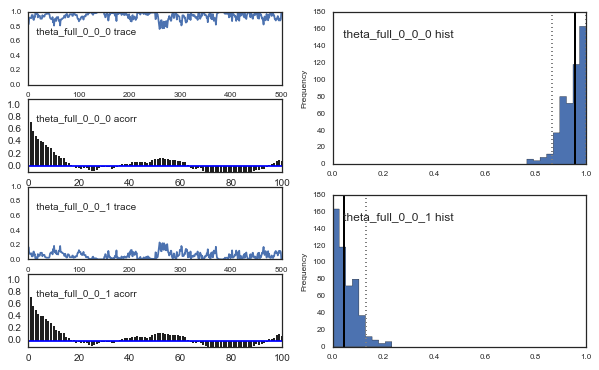

In [81]:
fig = plt.figure(figsize=(16,8))
pm.Matplot.plot(theta_full[0], new=False)

Plotting theta_full_1_0_0
Plotting theta_full_1_0_1


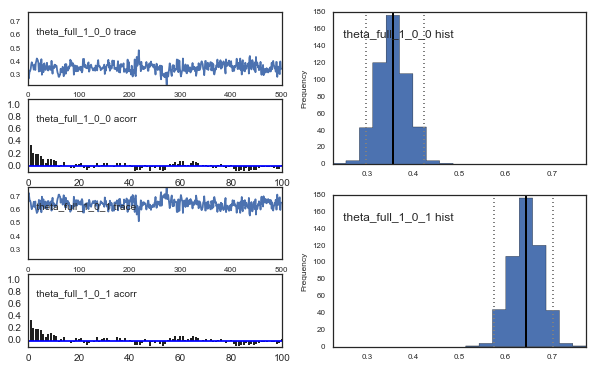

In [83]:
fig = plt.figure(figsize=(16,8))
pm.Matplot.plot(theta_full[1], new=False)

Plotting rho_0


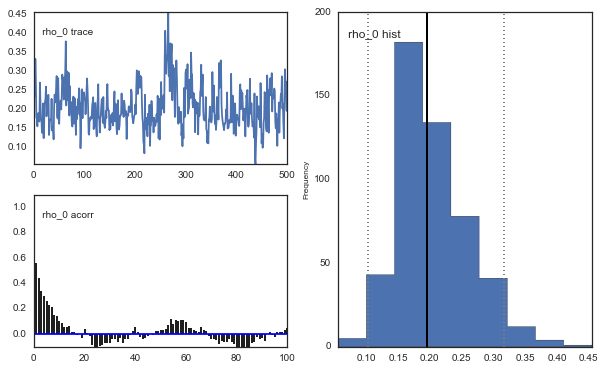

In [85]:
fig = plt.figure(figsize=(16,8))
pm.Matplot.plot(rho, new=False)

In [87]:
mcmc.summary()


z_71:
 
	Mean             SD               MC Error        95% HPD interval
	------------------------------------------------------------------
	0.774            0.418            0.022                  [ 0.  1.]
	0.226            0.418            0.022                  [ 0.  1.]
	
	
	Posterior quantiles:
	
	2.5             25              50              75             97.5
	 |---------------|===============|===============|---------------|
	0.0              1.0             1.0            1.0           1.0
	0.0              0.0             0.0            0.0           1.0
	

z_53:
 
	Mean             SD               MC Error        95% HPD interval
	------------------------------------------------------------------
	0.0              0.0              0.0                    [ 0.  0.]
	1.0              0.0              0.0                    [ 1.  1.]
	
	
	Posterior quantiles:
	
	2.5             25              50              75             97.5
	 |---------------|===============|=====

In [88]:
mcmc.stats()

{'rho': {'95% HPD interval': array([ 0.10314015,  0.31668735]),
  'mc error': 0.0042460439824963583,
  'mean': 0.20523397388831383,
  'n': 500,
  'quantiles': {2.5: 0.11060722000261701,
   25: 0.16748573016503737,
   50: 0.19616755753455095,
   75: 0.23677310104057198,
   97.5: 0.32814348241593516},
  'standard deviation': 0.055520467665652412},
 'theta_0': {'95% HPD interval': array([ 0.86617806,  0.99967129]),
  'mc error': 0.0037668436042530085,
  'mean': 0.94413256097357734,
  'n': 500,
  'quantiles': {2.5: 0.82729193333773388,
   25: 0.91649966330497845,
   50: 0.95628287019164593,
   75: 0.98040005575132783,
   97.5: 0.99804058088406711},
  'standard deviation': 0.045524384252407658},
 'theta_1': {'95% HPD interval': array([ 0.29785345,  0.42412846]),
  'mc error': 0.002136664847871163,
  'mean': 0.35588898858684204,
  'n': 500,
  'quantiles': {2.5: 0.28899056703580295,
   25: 0.33416639466962716,
   50: 0.35602567383223055,
   75: 0.37591191627046899,
   97.5: 0.4199906363196627

<div class="alert alert-info">
From the above output, we infer the <strong>estimated confusion matrix as: [[0.94, 0.06], [0.35, 0.64]] </strong> {the 95% HPD interval for the first row is ([0.87, 0.13], [1.0, 0.0]), and for the second row it is ([0.30, 0.70], [0.42, 0.58])}; and the <strong>estimated distribution of the (dog/cat) images to be: [0.21, 0.79] </strong> {the 95% HPD interval is actually ([0.10, 0.90], [0.32, 0.68])}. <br><br>

So it would seem that (a) the workers are much more likely to be able to correctly identify dogs (94%) rather than cats (64%), and (b) that there are more cats to be classified in the image set (which might make sense if you assume these images were given to the workers in the first place because they are more challenging to classify). 

<br><br>We note that it is a much more difficult task to actually infer the true labels of particular images ("The problems are mainly caused by the nonidentifiability of the components under symmetric priors, which leads to so called label switching in the MCMC output. This will mean that ergodic averages of component specific quantities will be identical and thus useless for inference.": http://www.stats.ox.ac.uk/~cholmes/Reports/mcmc_label_switching_holmes.pdf)
</div>